In [ ]:
 
        #             "table_summaries": table_summaries,
        #             "image_summaries": image_summaries,
        #         

In [60]:
import pickle

# Path to your saved pickle file
pickle_file_path = "/home/metacloud/Documents/multi_modal_rag/pdf_pickle_output/pdf_data.pkl"
summary_file = "/home/metacloud/Documents/multi_modal_rag/pdf_pickle_output/summary.pkl"
# Load the data
with open(pickle_file_path, "rb") as f:
    data = pickle.load(f)

# Access the variables
texts = data["texts"]
tables = data["tables"]
images = data["images"]


with open(summary_file, "rb") as f:
    summary = pickle.load(f)

table_summary = summary["table_summaries"]
image_summary = summary["image_summaries"]



print(f"Loaded {len(texts)} text blocks, {len(tables)} tables, and {len(images)} images.")


Loaded 14 text blocks, 0 tables, and 640 images.


In [ ]:
text

In [ ]:
clean_summaries = []
clean_ids = []
for i, summary in enumerate(texts):
    if isinstance(summary, str):
        clean_summaries.append(summary)
        clean_ids.append(doc_ids[i])
    else:
        # convert object to string or skip
        try:
            summary_str = str(summary)
            clean_summaries.append(summary_str)
            clean_ids.append(doc_ids[i])
        except Exception as e:
            print(f"[WARN] Skipping non-string summary: {e}")


In [76]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import LocalFileStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import OllamaEmbeddings
import base64
embedding_model = OllamaEmbeddings(model="nomic-embed-text:latest")



def get_vdb_retriever(
    collection_name: str = "multi_modal_rag",
    persist_directory: str = "./chroma_db",
    docstore_path: str = "./docstore",
    id_key: str = "doc_id",
) -> MultiVectorRetriever:
    """
    Initializes and returns a persistent MultiVectorRetriever using Chroma for vector storage
    and LocalFileStore for document storage.

    This setup enables storing embeddings and associated documents on the file system,
    ensuring data persists across sessions.

    Args:
        collection_name (str): Name of the Chroma collection to use or create.
        persist_directory (str): Path to the directory where Chroma will store vectors.
        docstore_path (str): Path to the directory where documents will be stored as files.
        id_key (str): The key used to identify documents uniquely.

    Returns:
        MultiVectorRetriever: A retriever capable of storing and retrieving multimodal documents
        using both vector similarity and document ID-based lookups.
    """
    # Persistent Chroma vector store
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=embedding_model,
        persist_directory=persist_directory,
    )

    # Persistent document store on file system
    store = LocalFileStore(docstore_path)

    # Initialize the retriever with persistent vectorstore and docstore
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    return retriever



def upsert(
    retriever: MultiVectorRetriever,
    texts: list = None,
    text_summaries: list = None,
    tables: list = None,
    table_summaries: list = None,
    images: list = None,
    image_summaries: list = None,
    id_key: str = "doc_id",
) -> bool:
    # Add texts


    if texts and text_summaries:
        doc_ids = [str(uuid.uuid4()) for _ in texts]
        clean_summaries = []
        clean_ids = []
        for i, summary in enumerate(text_summaries):
            if isinstance(summary, str):
                clean_summaries.append(summary)
                clean_ids.append(doc_ids[i])
            else:
                try:
                    clean_summaries.append(str(summary))
                    clean_ids.append(doc_ids[i])
                except Exception as e:
                    print(f"[WARN] Skipping invalid summary at index {i}: {e}")

        summary_texts = [
            Document(page_content=s, metadata={id_key: clean_ids[idx]})
            for idx, s in enumerate(clean_summaries)
        ]

        retriever.vectorstore.add_documents(summary_texts)
        # byte_texts = [t.encode("utf-8") for t in texts[:len(clean_ids)]]
        byte_texts = [str(t).encode("utf-8") for t in texts[:len(clean_ids)]]
        retriever.docstore.mset(list(zip(clean_ids, byte_texts)))
        print("Text upserted")



    # if texts:
    #     doc_ids = [str(uuid.uuid4()) for _ in texts]
    #     summary_texts = [
    #         Document(page_content=summary, metadata={id_key: doc_ids[i]})
    #         for i, summary in enumerate(text_summaries)
    #     ]
    #     retriever.vectorstore.add_documents(summary_texts)
    #     retriever.docstore.mset(list(zip(doc_ids, [t.encode("utf-8") for t in texts])))
    #     print("Text upserted")

    # # Add tables
    # if tables:
    #     table_ids = [str(uuid.uuid4()) for _ in tables]
    #     summary_tables = [
    #         Document(page_content=summary, metadata={id_key: table_ids[i]})
    #         for i, summary in enumerate(table_summaries)
    #     ]
    #     retriever.vectorstore.add_documents(summary_tables)
    #     retriever.docstore.mset(list(zip(table_ids, tables)))
    #     print("Table upserted")


    if tables and table_summaries:
        doc_ids = [str(uuid.uuid4()) for _ in texts]
        clean_summaries = []
        clean_ids = []
        for i, summary in enumerate(text_summaries):
            if isinstance(summary, str):
                clean_summaries.append(summary)
                clean_ids.append(doc_ids[i])
            else:
                try:
                    clean_summaries.append(str(summary))
                    clean_ids.append(doc_ids[i])
                except Exception as e:
                    print(f"[WARN] Skipping invalid summary at index {i}: {e}")

            summary_texts = [
                Document(page_content=s, metadata={id_key: clean_ids[idx]})
                for idx, s in enumerate(clean_summaries)
            ]

        retriever.vectorstore.add_documents(summary_texts)
        byte_texts = [t.encode("utf-8") for t in texts[:len(clean_ids)]]
        retriever.docstore.mset(list(zip(clean_ids, byte_texts)))
        print("Text upserted")

    # #Add image summaries
    if images:
        img_ids = [str(uuid.uuid4()) for _ in images]
        summary_img = [
            Document(page_content=summary, metadata={id_key: img_ids[i]})
            for i, summary in enumerate(image_summaries)
        ]
        retriever.vectorstore.add_documents(summary_img)

        image_bytes = [base64.b64decode(img_str) for img_str in images]
        retriever.docstore.mset(list(zip(img_ids, image_bytes)))

        print("Images Upserted.")


    # if images:
    # img_ids = [str(uuid.uuid4()) for _ in images]
    # summary_img = [
    #     Document(page_content=summary, metadata={id_key: img_ids[i]})
    #     for i, summary in enumerate(image_summaries)
    # ]
    # retriever.vectorstore.add_documents(summary_img)

    # # Convert base64 strings to bytes
    # image_bytes = [base64.b64decode(img_str) for img_str in images]
    # retriever.docstore.mset(list(zip(img_ids, image_bytes)))



    return True


In [77]:
r = get_vdb_retriever()
upsert(r,texts[:2],texts[:2],tables,table_summary,images[:2],image_summary[:2])

Text upserted
Images Upserted.


True

In [45]:
image_summary

['The image depicts a simple Artificial Neural Network (ANN) architecture, which is a fundamental concept in machine learning. Here\'s a detailed description of the image:\n\n**Overview**\n\nThe image shows a feedforward neural network with three layers: an input layer, a hidden layer, and an output layer.\n\n**Layers and Nodes**\n\n* **Input Layer**: The input layer consists of four nodes, labeled as "Input 1", "Input 2", "Input 3", and "Input 4". These nodes represent the features or inputs to the network.\n* **Hidden Layer**: The hidden layer consists of three nodes, which are not labeled. These nodes are responsible for processing the inputs and transforming them into a more useful representation.\n* **Output Layer**: The output layer consists of a single node, labeled as "Output". This node represents the predicted output of the network.\n\n**Connections and Arrows**\n\nThe nodes in each layer are connected to the nodes in the next layer through arrows, which represent the flow of

In [30]:
from dotenv import load_dotenv
import os
from langchain_core.runnables import RunnableSequence


load_dotenv()
api_key = os.environ["GROQ_API_KEY"]


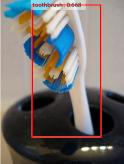

In [61]:

import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[-2])

In [22]:
td = texts[0].to_dict()

In [23]:
td

{'type': 'CompositeElement',
 'element_id': '5a79ad716599d3f1f6b79ea97e0eac33',
 'text': 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks\n\nShaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun\n\n6 1 0 2 n a J 6 ] V C . s c [ 3 v 7\n\nAbstract—State-of-the-art object detection networks depend on region proposal algorithms to hypothesize object locations. Advances like SPPnet [1] and Fast R-CNN [2] have reduced the running time of these detection networks, exposing region proposal computation as a bottleneck. In this work, we introduce a Region Proposal Network (RPN) that shares full-image convolutional features with the detection network, thus enabling nearly cost-free region proposals. An RPN is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals, which are used by Fast R-CNN for detection. We further merge RPN and Fast R

In [24]:
td.keys()

dict_keys(['type', 'element_id', 'text', 'metadata'])

In [25]:
final_texts = []
final_tables = []
for text in texts:
    td = text.to_dict()
    clean_text = td['text']
    final_texts.append(clean_text)
    table = td.get("metadata", {}).get("text_as_html")
    # td["metadata"]["text_as_html"]
    if table:
        table = td["metadata"]["text_as_html"]
        final_tables.append(table)


In [26]:
final_tables

['<table><thead><tr><th>method</th><th># boxes</th><th>method</th><th># proposals</th><th>| mAP (%)</th></tr></thead><tbody><tr><td>Ss</td><td>2000</td><td>Ss</td><td>2000</td><td>58.7</td></tr><tr><td>EB</td><td>2000</td><td>EB</td><td>2000</td><td>58.6</td></tr><tr><td>RPN+ZE, shared</td><td>2000</td><td>RPN+2ZEF, shared</td><td>300</td><td>59.9</td></tr><tr><td colspan="5">ablation experiments follow below</td></tr><tr><td>RPN+ZE, unshared</td><td>2000</td><td>RPN+ZE, unshared</td><td>300</td><td>58.7</td></tr><tr><td>Ss</td><td>2000</td><td>RPN+ZF</td><td>100</td><td>55.1</td></tr><tr><td>Ss</td><td>2000</td><td>RPN+ZF</td><td>300</td><td>56.8</td></tr><tr><td>Ss</td><td>2000</td><td>RPN+ZF</td><td>1000</td><td>56.3</td></tr><tr><td>SS</td><td>2000</td><td>RPN+ZF (no NMS)</td><td>6000</td><td>55.2</td></tr><tr><td>Ss</td><td>2000</td><td>RPN+ZF (no cls)</td><td>100</td><td>44.6</td></tr><tr><td>SS</td><td>2000</td><td>RPN+2ZEF (no cls)</td><td>300</td><td>51.4</td></tr><tr><td>SS</

In [27]:
from bs4 import BeautifulSoup
from IPython.display import display, HTML

# Parse with BeautifulSoup
soup = BeautifulSoup(final_tables[4], 'html.parser')

# Extract and display each table
tables = soup.find_all('table')
for i, table in enumerate(tables):
    print(f"Table {i+1}:")
    display(HTML(str(table)))

Table 1:


method,proposals},training data,mAP@5,"|mAP@L[.5, .95]|",mAP@.5,"|/mAP@[.5, .95]"
Fast R-CNN [2],"SS, 2000 |",COCO train,-,-,35.9,19.7
Fast R-CNN [impl. in this paper]|,"SS, 2000",| COCO train,38.6,18.9,39.3,19.3
Faster R-CNN,"RPN, 300}",COCO train,41.5,21.2,42.1,21.5
Faster R-CNN,"RPN,",300|}COCO trainval,-,-,42.7,21.9


Table 2:


VOC07,69.9,| 67.0
VOC07+12 VOC07++12,73.2 -,- 70.4


In [28]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq  # or ChatOpenAI, as applicable

prompt = ChatPromptTemplate.from_template("""
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Table or text chunk: {element}
""")

llm = ChatGroq(temperature=0.3, model="llama3-8b-8192",api_key=api_key)  # or ChatOpenAI(...)

format_runnable = RunnableLambda(lambda inputs: prompt.format_prompt(element=inputs["element"]))

summarize_chain = format_runnable | llm | StrOutputParser()

inputs = [{"element": text} for text in final_texts]
inputs = inputs[:3]

output = summarize_chain.batch(inputs, {"max_concurrency": 3})

for i, summary in enumerate(output):
    print(f"--- Summary {i+1} ---\n{summary}\n")


AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

In [51]:
final_texts[0]

'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks\n\nShaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun\n\n6 1 0 2 n a J 6 ] V C . s c [ 3 v 7\n\nAbstract—State-of-the-art object detection networks depend on region proposal algorithms to hypothesize object locations. Advances like SPPnet [1] and Fast R-CNN [2] have reduced the running time of these detection networks, exposing region proposal computation as a bottleneck. In this work, we introduce a Region Proposal Network (RPN) that shares full-image convolutional features with the detection network, thus enabling nearly cost-free region proposals. An RPN is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals, which are used by Fast R-CNN for detection. We further merge RPN and Fast R-CNN into a single network by sharing their convolutional features—using the recently pop

In [31]:


vision_model =  ChatGroq(
        model_name="meta-llama/llama-4-scout-17b-16e-instruct",
        api_key=api_key,
        temperature=0,
        
    )
def generate_images_summary(images, images_background_context: str = None):

    prompt_template = f"""Describe the image in detail.{images_background_context}"""
    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | vision_model | StrOutputParser()

    image_summaries = chain.batch(images)
    print(image_summaries)

    return image_summaries

In [35]:
def generate_images_summary(images, images_background_context: str = None):
    prompt_template = f"""Describe the image in detail.{images_background_context}"""
    image_summaries = []

    for image in images:
        try:
            messages = [
                (
                    "user",
                    [
                        {"type": "text", "text": prompt_template},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                        },
                    ],
                )
            ]

            prompt = ChatPromptTemplate.from_messages(messages)
            chain = prompt | vision_model | StrOutputParser()
            summary = chain.invoke({})
            image_summaries.append(summary)

        except Exception as e:
            print(f"[WARN] Skipping image due to error: {e}")
            continue

    print(image_summaries)
    return image_summaries



t = """
Images are from 
Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
Paper. they shows images of different scenes in real time and agrumented image.
"""
s = generate_images_summary(images[:10],t)

['The image depicts a scene of a man riding a horse, with the horse in motion. The man is dressed in a blue shirt and jeans, while the horse is brown with white markings on its face and hooves.\n\n**Key Elements:**\n\n*   **Man:** Wearing a blue shirt and jeans, riding a horse.\n*   **Horse:** Brown with white markings on its face and hooves, appears to be running or jumping.\n*   **Background:** \n    *   A truck is parked on the left side.\n    *   A person wearing red is standing on the right side.\n    *   Trees and a fence are visible in the background.\n    *   A blue tarp or blanket is on the ground behind the truck.\n\n**Image Features:**\n\n*   The image is labeled with "image" at the bottom and "feature map" at the top, indicating that it may be used to illustrate a concept related to image processing or computer vision.\n*   The image appears to be a real-world scene, possibly used for testing or demonstrating object detection algorithms, as suggested by the context of the p

In [36]:
s

['The image depicts a scene of a man riding a horse, with the horse in motion. The man is dressed in a blue shirt and jeans, while the horse is brown with white markings on its face and hooves.\n\n**Key Elements:**\n\n*   **Man:** Wearing a blue shirt and jeans, riding a horse.\n*   **Horse:** Brown with white markings on its face and hooves, appears to be running or jumping.\n*   **Background:** \n    *   A truck is parked on the left side.\n    *   A person wearing red is standing on the right side.\n    *   Trees and a fence are visible in the background.\n    *   A blue tarp or blanket is on the ground behind the truck.\n\n**Image Features:**\n\n*   The image is labeled with "image" at the bottom and "feature map" at the top, indicating that it may be used to illustrate a concept related to image processing or computer vision.\n*   The image appears to be a real-world scene, possibly used for testing or demonstrating object detection algorithms, as suggested by the context of the p

In [33]:
len(images)

640

In [18]:
def generate_images_summary(images, images_background_context: str = None):
    prompt_template = f"""Describe the image in detail.{images_background_context}"""
    
    vision_model = ChatGroq(
        model_name="meta-llama/llama-4-scout-17b-16e-instruct",
        api_key="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",
        temperature=0,
    )

    image_summaries = []

    for image in images:
        try:
            messages = [
                (
                    "user",
                    [
                        {"type": "text", "text": prompt_template},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image['image']}"},
                        },
                    ],
                )
            ]

            prompt = ChatPromptTemplate.from_messages(messages)
            chain = prompt | vision_model | StrOutputParser()

            summary = chain.invoke({})
            image_summaries.append(summary)

        except Exception as e:
            print(f"[WARN] Skipping image due to error: {e}")
            continue

    return image_summaries


In [19]:
out = generate_images_summary(images[:3], t)


[WARN] Skipping image due to error: string indices must be integers, not 'str'
[WARN] Skipping image due to error: string indices must be integers, not 'str'
[WARN] Skipping image due to error: string indices must be integers, not 'str'


In [8]:
images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABuAV8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCL4r/DCXTJZfEGgws9nIWe6to4+LbjO5QP4OvGPl+nTy3TLeO9uhHLNHChBO9xhenfANfaciLJGyOoZWBDKRkEeleBfEz4bLoLya1pMAOmOyiSFckwcdR/sZHrxn06ZzWmhElpoedyaaltNJHHfggnarAAhh74JxUkrXdpat

In [ ]:
import os
import base64
from langchain.chat_models import ChatGroq
from langchain.prompts.chat import ChatPromptTemplate
from langchain.output_parsers import StrOutputParser

# def encode_image_to_base64(image_path):
#     with open(image_path, "rb") as f:
#         return base64.b64encode(f.read()).decode("utf-8")

def generate_images_summary(image_paths, images_background_context: str = ""):
    # Compose the prompt template with placeholders for image + context
    prompt = ChatPromptTemplate.from_messages([
        (
            "user",
            [
                {"type": "text", "text": "Describe the image in detail."},
                {"type": "text", "text": images_background_context},
                {"type": "image_url", "image_url": {"url": "{image_url}"}},
            ],
        )
    ])

    # Initialize Groq LLM with vision-capable model
    groq_api_key = os.getenv("GROQ_API_KEY")
    llm = ChatGroq(
        model_name="llama-3.2-vision-preview",  # or "llama-3.2-90b-vision-preview" for higher quality
        api_key=groq_api_key,
        temperature=0,
    )

    # Create chain (prompt -> llm -> string output)
    chain = prompt | llm | StrOutputParser()

    summaries = []
    for path in image_paths:
        b64 = encode_image_to_base64(path)
        # Fill in the prompt input variables dynamically
        summary = chain.invoke({"image_url": f"data:image/jpeg;base64,{b64}"})
        summaries.append(summary)

    return summaries

if __name__ == "__main__":
    paths = ["example1.jpg", "example2.png"]
    context = "These images are from the latest marketing campaign."
    results = generate_images_summary(paths, context)
    for i, s in enumerate(results):
        print(f"Image {i+1} summary:\n{s}\n")
